In [211]:
import pandas
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV

# Klasifikatori

In [212]:
def get_fscore(y_test, y_pred):
    precision, recall, fscore, support=score(y_test, y_pred, average='macro')
    return fscore

## KNN

In [213]:
#ucitavanje
train_df = pandas.read_csv('datasets/train.csv')
X_train = train_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_train = train_df.iloc[:, 4].values

test_df = pandas.read_csv('datasets/test.csv')
X_test = test_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_test = test_df.iloc[:, 4].values

validation_df = pandas.read_csv('datasets/validation.csv')
X_validation = validation_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_validation = validation_df.iloc[:, 4].values

#normalizacija
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

#optimizacija k
min_error = float('inf')
k = 1
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_validation)
    error = np.mean(pred_i != y_validation)
    if error < min_error:
        min_error = error
        k = i
    
print('k: ' + str(k))

#treniranje
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)

#predikcija
y_pred = knn.predict(X_test)

k: 6


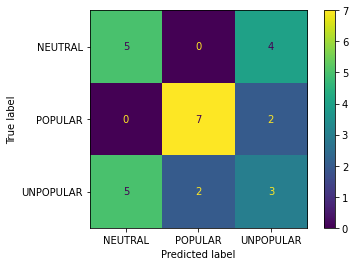

In [214]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=knn.classes_
)
disp.plot()
plt.show()

In [215]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     NEUTRAL       0.50      0.56      0.53         9
     POPULAR       0.78      0.78      0.78         9
   UNPOPULAR       0.33      0.30      0.32        10

    accuracy                           0.54        28
   macro avg       0.54      0.54      0.54        28
weighted avg       0.53      0.54      0.53        28



In [216]:
scores = {}

fscore = get_fscore(y_test, y_pred)
print('current fscore: ', fscore)

try:
    filename = 'models/knn.pickle'
    stored_model = pickle.load(open(filename, 'rb'))
    y_pred = stored_model.predict(X_test)

    old_fscore = get_fscore(y_test, y_pred)
    print('old fscore:', old_fscore)

    if fscore > old_fscore:
        pickle.dump(knn, open(filename, 'wb'))
        print('saved')
        scores['knn'] = fscore
    else:
        scores['knn'] = old_fscore
except FileNotFoundError:
    pickle.dump(knn, open(filename, 'wb'))
    print('saved')
    scores['knn'] = fscore

current fscore:  0.5399610136452241
old fscore: 0.6245822890559732


## Logistic Regression

In [217]:
#ucitavanje
train_df = pandas.read_csv('datasets/train.csv')
X_train = train_df.iloc[:, [2, 3, 5, 6, 7, 8, 9, 11]].values
y_train = train_df.iloc[:, 4].values

test_df = pandas.read_csv('datasets/test.csv')
X_test = test_df.iloc[:, [2, 3, 5, 6, 7, 8, 9, 11]].values
y_test = test_df.iloc[:, 4].values

validation_df = pandas.read_csv('datasets/validation.csv')
X_validation = validation_df.iloc[:, [2, 3, 5, 6, 7, 8, 9, 11]].values
y_validation = validation_df.iloc[:, 4].values

#normalizacija
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

#optimizacija parametara
min_error = float('inf')
solvers = ['lbfgs', 'sag', 'newton-cg', 'saga']
c_values = [100, 10, 1.0, 0.5, 0.3, 0.1, 0.05, 0.03, 0.01, 0.001]
solver = ''
c = 0
for s in solvers:
    print(s);
    for c_value in c_values:
        lr = LogisticRegression(penalty='l2', solver=s, max_iter=5000, C=c_value, random_state=0).fit(X_train, y_train)
        pred_sc = lr.predict(X_validation)
        error = np.mean(pred_sc != y_validation)
        print('[C: ' + str(c_value) + ', error: ' + str(round(error, 5)), end ="] ")
        if error < min_error:
            min_error = error
            solver = s
            c = c_value
    print('')
    
print('\n' + 'solver: ' + solver)
print('C: ' + str(c))

#traniranje
lr = LogisticRegression(penalty='l2', max_iter=5000, solver=solver, C=c, random_state=0).fit(X_train, y_train)

#predikcija
y_pred = lr.predict(X_test)

lbfgs
[C: 100, error: 0.46429] [C: 10, error: 0.46429] [C: 1.0, error: 0.46429] [C: 0.5, error: 0.46429] [C: 0.3, error: 0.42857] [C: 0.1, error: 0.35714] [C: 0.05, error: 0.35714] [C: 0.03, error: 0.35714] [C: 0.01, error: 0.35714] [C: 0.001, error: 0.35714] 
sag
[C: 100, error: 0.46429] [C: 10, error: 0.46429] [C: 1.0, error: 0.46429] [C: 0.5, error: 0.46429] [C: 0.3, error: 0.42857] [C: 0.1, error: 0.35714] [C: 0.05, error: 0.35714] [C: 0.03, error: 0.35714] [C: 0.01, error: 0.35714] [C: 0.001, error: 0.35714] 
newton-cg
[C: 100, error: 0.46429] [C: 10, error: 0.46429] [C: 1.0, error: 0.46429] [C: 0.5, error: 0.46429] [C: 0.3, error: 0.42857] [C: 0.1, error: 0.35714] [C: 0.05, error: 0.35714] [C: 0.03, error: 0.35714] [C: 0.01, error: 0.35714] [C: 0.001, error: 0.35714] 
saga
[C: 100, error: 0.46429] [C: 10, error: 0.46429] [C: 1.0, error: 0.46429] [C: 0.5, error: 0.46429] [C: 0.3, error: 0.42857] [C: 0.1, error: 0.35714] [C: 0.05, error: 0.35714] [C: 0.03, error: 0.35714] [C: 0.01,

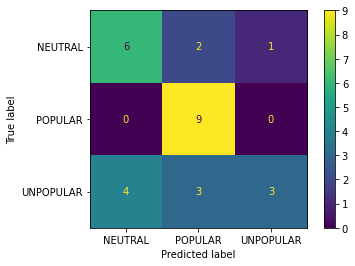

In [218]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=lr.classes_
)
disp.plot()
plt.show()

In [219]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     NEUTRAL       0.60      0.67      0.63         9
     POPULAR       0.64      1.00      0.78         9
   UNPOPULAR       0.75      0.30      0.43        10

    accuracy                           0.64        28
   macro avg       0.66      0.66      0.61        28
weighted avg       0.67      0.64      0.61        28



In [220]:
fscore = get_fscore(y_test, y_pred)
print('current fscore: ', fscore)

try:
    filename = 'models/lr.pickle'
    stored_model = pickle.load(open(filename, 'rb'))
    y_pred = stored_model.predict(X_test)

    old_fscore = get_fscore(y_test, y_pred)
    print('old fscore:', old_fscore)

    if fscore > old_fscore:
        pickle.dump(lr, open(filename, 'wb'))
        print('saved')
        scores['loristic regression'] = fscore
    else:
        scores['logistic regression'] = old_fscore
except FileNotFoundError:
    pickle.dump(lr, open(filename, 'wb'))
    print('saved')
    scores['logistic regression'] = fscore

current fscore:  0.6142530238640078
old fscore: 0.6142530238640078


## Support Vector Classification

In [221]:
#ucitavanje
train_df = pandas.read_csv('datasets/train.csv')
X_train = train_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_train = train_df.iloc[:, 4].values

test_df = pandas.read_csv('datasets/test.csv')
X_test = test_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_test = test_df.iloc[:, 4].values

validation_df = pandas.read_csv('datasets/validation.csv')
X_validation = validation_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_validation = validation_df.iloc[:, 4].values

#normalizacija
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

#optimizacija parametara
min_error = float('inf')
kernel_functions = ['linear', 'poly', 'rbf', 'sigmoid']
gamma_values = ['scale', 'auto']
c_values = [100, 10, 1.0, 0.1, 0.01]
kernel = ''
c = 0
gamma = ''
for kernel_function in kernel_functions:
    print(kernel_function);
    for c_value in c_values:
        for gamma_value in gamma_values:
            svc = SVC(kernel=kernel_function, C=c_value, gamma=gamma_value).fit(X_train, y_train)
            pred_i = svc.predict(X_validation)
            error = np.mean(pred_i != y_validation)
            print('[C: ' + str(c_value) + ', gamma: ' + gamma_value + ', error: ' + str(round(error, 5)), end ="] ")
            if error < min_error:
                min_error = error
                kernel = kernel_function
                c = c_value
                gamma = gamma_value
    print('')
    
print('\n' + 'kernel: ' + kernel)
print('C: ' + str(c))
print('gamma: ' + gamma)

#treniranje
svc = SVC(kernel=kernel, C=c, gamma=gamma).fit(X_train, y_train)

#predikcija
y_pred = svc.predict(X_test)

linear
[C: 100, gamma: scale, error: 0.53571] [C: 100, gamma: auto, error: 0.53571] [C: 10, gamma: scale, error: 0.5] [C: 10, gamma: auto, error: 0.5] [C: 1.0, gamma: scale, error: 0.42857] [C: 1.0, gamma: auto, error: 0.42857] [C: 0.1, gamma: scale, error: 0.42857] [C: 0.1, gamma: auto, error: 0.42857] [C: 0.01, gamma: scale, error: 0.39286] [C: 0.01, gamma: auto, error: 0.39286] 
poly
[C: 100, gamma: scale, error: 0.46429] [C: 100, gamma: auto, error: 0.46429] [C: 10, gamma: scale, error: 0.5] [C: 10, gamma: auto, error: 0.5] [C: 1.0, gamma: scale, error: 0.5] [C: 1.0, gamma: auto, error: 0.5] [C: 0.1, gamma: scale, error: 0.60714] [C: 0.1, gamma: auto, error: 0.60714] [C: 0.01, gamma: scale, error: 0.60714] [C: 0.01, gamma: auto, error: 0.60714] 
rbf
[C: 100, gamma: scale, error: 0.46429] [C: 100, gamma: auto, error: 0.46429] [C: 10, gamma: scale, error: 0.42857] [C: 10, gamma: auto, error: 0.42857] [C: 1.0, gamma: scale, error: 0.42857] [C: 1.0, gamma: auto, error: 0.42857] [C: 0.1

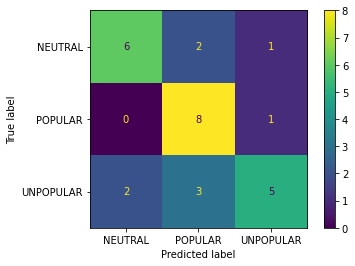

In [222]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=svc.classes_
)
disp.plot()
plt.show()

In [223]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     NEUTRAL       0.75      0.67      0.71         9
     POPULAR       0.62      0.89      0.73         9
   UNPOPULAR       0.71      0.50      0.59        10

    accuracy                           0.68        28
   macro avg       0.69      0.69      0.67        28
weighted avg       0.69      0.68      0.67        28



In [224]:
fscore = get_fscore(y_test, y_pred)
print('current fscore: ', fscore)

try:
    filename = 'models/svc.pickle'
    stored_model = pickle.load(open(filename, 'rb'))
    y_pred = stored_model.predict(X_test)

    old_fscore = get_fscore(y_test, y_pred)
    print('old fscore:', old_fscore)

    if fscore > old_fscore:
        pickle.dump(svc, open(filename, 'wb'))
        print('saved')
        scores['support vector classification'] = fscore
    else:
        scores['support vector classification'] = old_fscore
except FileNotFoundError:
    pickle.dump(svc, open(filename, 'wb'))
    print('saved')
    scores['support vector classification'] = fscore

current fscore:  0.6737967914438503
old fscore: 0.6737967914438503


## Naive Bayes

In [225]:
#ucitavanje
train_df = pandas.read_csv('datasets/train.csv')
X_train = train_df.iloc[:, [3, 6, 7, 8, 9, 10, 11]].values
y_train = train_df.iloc[:, 4].values

test_df = pandas.read_csv('datasets/test.csv')
X_test = test_df.iloc[:, [3, 6, 7, 8, 9, 10, 11]].values
y_test = test_df.iloc[:, 4].values

validation_df = pandas.read_csv('datasets/validation.csv')
X_validation = validation_df.iloc[:, [3, 6, 7, 8, 9, 10, 11]].values
y_validation = validation_df.iloc[:, 4].values

#normalizacija
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

#optimizacija
min_error = float('inf')
smoothing_values = np.logspace(-5,-9, num=50)
sm = 0

for i in smoothing_values:
    gnb = GaussianNB(var_smoothing=i).fit(X_train, y_train)
    pred_i = gnb.predict(X_validation)
    error = np.mean(pred_i != y_validation)
    if error < min_error:
        min_error = error
        sm = i
    
print('\n' + 'var_smoothing: ' + str(sm))

#treniranje
gnb = GaussianNB(var_smoothing=sm)
gnb.fit(X_train, y_train)
gnb.get_params()

#predikcija
y_pred = gnb.predict(X_test)


var_smoothing: 1e-05


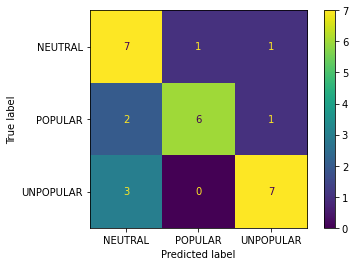

In [226]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=gnb.classes_
)
disp.plot()
plt.show()

In [227]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     NEUTRAL       0.58      0.78      0.67         9
     POPULAR       0.86      0.67      0.75         9
   UNPOPULAR       0.78      0.70      0.74        10

    accuracy                           0.71        28
   macro avg       0.74      0.71      0.72        28
weighted avg       0.74      0.71      0.72        28



In [228]:
fscore = get_fscore(y_test, y_pred)
print('current fscore: ', fscore)

try:
    filename = 'models/gnb.pickle'
    stored_model = pickle.load(open(filename, 'rb'))
    y_pred = stored_model.predict(X_test)

    old_fscore = get_fscore(y_test, y_pred)
    print('old fscore:', old_fscore)

    if fscore > old_fscore:
        pickle.dump(gnb, open(filename, 'wb'))
        print('saved')
        scores['naive bayes'] = fscore
    else:
        scores['naive bayes'] = old_fscore
except FileNotFoundError:
    pickle.dump(gnb, open(filename, 'wb'))
    print('saved')
    scores['naive bayes'] = fscore

current fscore:  0.7178362573099415
old fscore: 0.7178362573099415


## Decision Tree

In [229]:
#ucitavanje
train_df = pandas.read_csv('datasets/train.csv')
X_train = train_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_train = train_df.iloc[:, 4].values

test_df = pandas.read_csv('datasets/test.csv')
X_test = test_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_test = test_df.iloc[:, 4].values

validation_df = pandas.read_csv('datasets/validation.csv')
X_validation = validation_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_validation = validation_df.iloc[:, 4].values

#normalizacija
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

#optimizacija
depths = range(3, 100)
min_error = float('inf')
depth = 0
for d in depths:
    dtc = DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=42).fit(X_train, y_train)
    pred_i = dtc.predict(X_validation)
    error = np.mean(pred_i != y_validation)
    if error < min_error:
        min_error = error
        depth = d
        
print('depth: ' + str(depth))

#treniranje
dtc = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=42)
dtc.fit(X_train, y_train)

#predikcija
y_pred = dtc.predict(X_test)

depth: 7


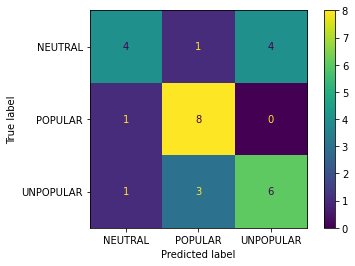

In [230]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=dtc.classes_
)
disp.plot()
plt.show()

In [231]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     NEUTRAL       0.67      0.44      0.53         9
     POPULAR       0.67      0.89      0.76         9
   UNPOPULAR       0.60      0.60      0.60        10

    accuracy                           0.64        28
   macro avg       0.64      0.64      0.63        28
weighted avg       0.64      0.64      0.63        28



In [232]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dtc, 
#                    feature_names=['total_ratings', 'median_property_price', 'total_stops', 'competitiveness', 'entropy'],  
#                    class_names=dtc.classes_,
#                    filled=True, rounded = True, proportion = False)

In [233]:
fscore = get_fscore(y_test, y_pred)
print('current fscore: ', fscore)

try:
    filename = 'models/dtc.pickle'
    stored_model = pickle.load(open(filename, 'rb'))
    y_pred = stored_model.predict(X_test)

    old_fscore = get_fscore(y_test, y_pred)
    print('old fscore:', old_fscore)

    if fscore > old_fscore:
        pickle.dump(dtc, open(filename, 'wb'))
        print('saved')
        scores['decision tree'] = fscore
    else:
        scores['decision tree'] = fscore
except FileNotFoundError:
    pickle.dump(dtc, open(filename, 'wb'))
    print('saved')
    scores['decision tree'] = fscore

current fscore:  0.6317460317460317
old fscore: 0.7855750487329435


## Random Forest Classifier

In [238]:
#ucitavanje
train_df = pandas.read_csv('datasets/train.csv')
X_train = train_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_train = train_df.iloc[:, 4].values

test_df = pandas.read_csv('datasets/test.csv')
X_test = test_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_test = test_df.iloc[:, 4].values

validation_df = pandas.read_csv('datasets/validation.csv')
X_validation = validation_df.iloc[:, [3, 5, 6, 7, 8, 9, 11]].values
y_validation = validation_df.iloc[:, 4].values

#normalizacija
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

# optimizacija n_estimators i max_depth i max_features
n_estimators = 20
max_depth = 20
max_features = 2
min_samples_split = 2
min_samples_leaf = 1
vfscore = 0
i_range = [20, 30, 50, 100, 150]
j_range = [20, 30, 50, 100, 150]
l_range = [2, 10, 20]
m_range = [1, 2, 3, 5]
for i in i_range: #estimators
    for j in j_range: #max depth
        for k in range(2, 5): #max features
            for l in l_range: #min samples split
                for m in m_range: #min samples leaf
                    rfc = RandomForestClassifier(
                        n_estimators=i, max_depth=j, max_features=k, 
                        min_samples_split=l, min_samples_leaf=m)
                    rfc.fit(X_train, y_train)
                    y_pred = rfc.predict(X_validation)
                    _, _, cfscore, _ = score(y_validation, y_pred, average='macro')
                    if vfscore < cfscore:
                        vfscore = cfscore
                        n_estimators = i
                        max_depth = j
                        max_features = k
                        min_samples_split = l
                        min_samples_leaf = m

print('estimators: ' + str(n_estimators))
print('max depth: ' + str(max_depth))
print('max features: ' + str(max_features))
print('min samples split: ' + str(min_samples_split))
print('min samples leaf: ' + str(min_samples_leaf))

# treniranje
rfc = RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features,
    min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# predikcija
y_pred = rfc.predict(X_test)

estimators: 30
max depth: 50
max features: 3
min samples split: 20
min samples leaf: 1


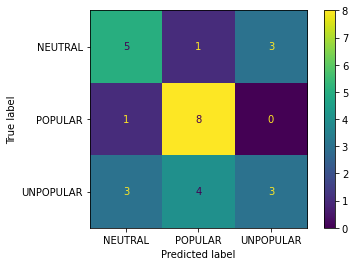

In [239]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=rfc.classes_
)
disp.plot()
plt.show()

In [240]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     NEUTRAL       0.56      0.56      0.56         9
     POPULAR       0.62      0.89      0.73         9
   UNPOPULAR       0.50      0.30      0.37        10

    accuracy                           0.57        28
   macro avg       0.56      0.58      0.55        28
weighted avg       0.55      0.57      0.55        28



In [241]:
fscore = get_fscore(y_test, y_pred)
print('current fscore: ', fscore)

try:
    filename = 'models/rfc.pickle'
    stored_model = pickle.load(open(filename, 'rb'))
    y_pred = stored_model.predict(X_test)

    old_fscore = get_fscore(y_test, y_pred)
    print('old fscore:', old_fscore)

    if fscore > old_fscore:
        pickle.dump(rfc, open(filename, 'wb'))
        print('saved')
        scores['random forest'] = fscore
    else:
        scores['random forest'] = old_fscore
except FileNotFoundError:
    pickle.dump(rfc, open(filename, 'wb'))
    print('saved')
    scores['random forest'] = fscore

current fscore:  0.5526094276094277
old fscore: 0.8218782249742002


# Rezultat

In [242]:
model = max(scores, key = lambda k: scores[k])
score = scores[model]
print(model, ': ', score)

random forest :  0.8218782249742002


# Kontrolna tacka 2

1. stops_count atribut umesto broja stanica sada se racuna po formuli
2. objekti mogu imati vise od jedne kategorije i formule su prilagodjene tome
3. dodat je tsq_distance atribut koji predstavlja udaljenost od centra grada
4. vracen atribut rating
5. skinuti komentari za lokaciju i dodat atribut negative_tips
6. dodat atribut positive_tips_percent = sqrt(positive_percent)
7. optimizovani hiperparametri 